In [40]:
import torch
from yo_fluq_ds import *
from tg.common.ml import batched_training as bt
from tg.grammar_ru.common import Loc, DataBundle
from tg.common.ml.batched_training import Batcher
from tg.grammar_ru.ml.features import PyMorphyFeaturizer
from tg.common.ml.batched_training import IndexedDataBundle
from tg.common.ml.batched_training import train_display_test_split
from tg.grammar_ru.ml.components.core_extractor.extractor import CoreExtractor
from tg.grammar_ru.ml.components.plain_context_builder import PlainContextBuilder
from tg.grammar_ru.ml.components.contextual_binding import ContextualBinding, ContextualNetworkType

Сначала копипаста прошлой части:

In [41]:
db = DataBundle.load(Loc.bundles_path/'antcd/wwd')
db.index

,pronoun_word_id,pronoun_sentence_id,candidate_word_id,candidate_sentence_id,candidate_distance,is_match,word_distance
sample_id,,,,,,,
0,7,0,4,0,1,1,3
1,7,0,5,0,0,0,2
2,514887,514880,514884,514880,1,1,3
3,514887,514880,514885,514880,0,0,2
4,1903357,1903337,1903342,1903335,3,0,12
...,...,...,...,...,...,...,...
101060,22837552,22837430,22837513,22837429,4,0,33
101061,22837552,22837430,22837524,22837430,3,0,25
101062,22837552,22837430,22837537,22837430,2,0,14


In [42]:
db.index = db.index.iloc[:1000]
db.index = db.index.rename(columns={'is_match': 'label'})
db.index['split'] = train_display_test_split(db.index)
db.index

,pronoun_word_id,pronoun_sentence_id,candidate_word_id,candidate_sentence_id,candidate_distance,label,word_distance,split
sample_id,,,,,,,,
0,7,0,4,0,1,1,3,display
1,7,0,5,0,0,0,2,display
2,514887,514880,514884,514880,1,1,3,train
3,514887,514880,514885,514880,0,0,2,train
4,1903357,1903337,1903342,1903335,3,0,12,train
...,...,...,...,...,...,...,...,...
995,2011233,2010938,2011213,2010935,2,0,14,display
996,2011233,2010938,2011223,2010937,1,0,7,train
997,2011233,2010938,2011227,2010937,0,1,4,test


In [43]:
idb = IndexedDataBundle(db.index, db)
idb

In [44]:
from tg.grammar_ru.ml.components.training_task_factory import TaskFactory, Conventions

def get_binary_label_extractor():
    label_extractor = (bt.PlainExtractor
                       .build(Conventions.LabelFrame)
                       .index()
                       .apply(take_columns=['label'], transformer=None))
    return label_extractor

def get_plain_context(sentence_id_column_name, word_id_column_name, context_name):
    pcb = PlainContextBuilder(include_zero_offset=True, left_to_right_contexts_proportion=0.5)
    pcb.sentence_id_column_name = sentence_id_column_name
    pcb.word_id_column_name = word_id_column_name
    plain_context = ContextualBinding(
        name=context_name,
        context_length=3,
        network_type=ContextualNetworkType.Plain,
        hidden_size=[30],
        context_builder=pcb,
        extractor=CoreExtractor(join_column='another_word_id'),
        debug=False
    )
    return plain_context

In [45]:
pronoun_pc = get_plain_context('pronoun_sentence_id', 'pronoun_word_id', 'pronoun_context')
pronoun_head_factory = pronoun_pc.create_network_factory(task=None, input=None)
candidate_pc = get_plain_context('candidate_sentence_id', 'candidate_word_id', 'candidate_context')
candidate_head_factory = candidate_pc.create_network_factory(task=None, input=None)

context_extractors = [pronoun_pc.create_extractor(task=None, bundle=db),
                      candidate_pc.create_extractor(task=None, bundle=db)]
for extractor in context_extractors:
    extractor.fit(idb)
    
pronoun_extractor = pronoun_pc.create_extractor(task=None, bundle=idb)
candidate_extractor = candidate_pc.create_extractor(task=None, bundle=idb)
batch = (Batcher(batch_size=1000, extractors=[pronoun_extractor, candidate_extractor, get_binary_label_extractor()])
         .fit_extract(idb))


2022-12-08 17:43:30.407832+00:00 INFO: Fitting extractor pymorphy in CoreExtractor
2022-12-08 17:43:30.885068+00:00 INFO: Success
2022-12-08 17:43:30.887069+00:00 INFO: Fitting extractor slovnet_morph in CoreExtractor
2022-12-08 17:43:31.393282+00:00 INFO: Success
2022-12-08 17:43:31.397281+00:00 INFO: Fitting extractor slovnet_syntax in CoreExtractor
2022-12-08 17:43:31.801900+00:00 INFO: Success
2022-12-08 17:43:31.812900+00:00 INFO: Fitting extractor syntax_fixes in CoreExtractor
2022-12-08 17:43:31.821904+00:00 INFO: Skipped as the corresponding frame is missing from the bundle
2022-12-08 17:43:31.837907+00:00 INFO: Fitting extractor syntax_stats in CoreExtractor
2022-12-08 17:43:31.842908+00:00 INFO: Skipped as the corresponding frame is missing from the bundle
2022-12-08 17:43:34.525607+00:00 INFO: Fitting extractor pymorphy in CoreExtractor
2022-12-08 17:43:35.091558+00:00 INFO: Success
2022-12-08 17:43:35.091558+00:00 INFO: Fitting extractor slovnet_morph in CoreExtractor
2022-

In [46]:
list(batch)

['index', 'pronoun_context', 'candidate_context', 'label']

In [47]:
from tg.common.ml.batched_training.torch.networks.simple_networks import FullyConnectedNetwork

class MyCandidateNetwork(torch.nn.Module):
    def __init__(self, batch, pronoun_head, candidate_head, tail_network_size):
        super(MyCandidateNetwork, self).__init__()
        self.pronoun_head = pronoun_head
        self.candidate_head = candidate_head
        heads_output = self._head_step(batch)
        self.fully_connected = FullyConnectedNetwork([tail_network_size, 1], heads_output)
        
    def _head_step(self, batch):
        pronoun_out = self.pronoun_head(batch)
        candidate_out = self.candidate_head(batch)
        concat = torch.cat([pronoun_out, candidate_out], dim=1)
        return concat
        
    def forward(self, batch):
        heads_output = self._head_step(batch)
        return self.fully_connected(heads_output)
        
class MyCandidateNetworkFactory:
    def __init__(self, pronoun_pc, candidate_pc, tail_network_size):
        self.pronoun_pc = pronoun_pc
        self.candidate_pc = candidate_pc
        self.tail_network_size = tail_network_size
        
    def create(self, task, batch):
        pronoun_head = pronoun_pc.create_network_factory(task=None, input=None).create_network(task=None, input=batch)
        candidate_head = candidate_pc.create_network_factory(task=None, input=None).create_network(task=None, input=batch)
        return MyCandidateNetwork(batch, pronoun_head, candidate_head, self.tail_network_size)
        
network_factory = MyCandidateNetworkFactory(pronoun_pc, candidate_pc, 50)
network = network_factory.create(None, batch)
network(batch)

tensor([[0.5806],
        [0.5807],
        [0.5806],
        [0.5807],
        [0.5791],
        [0.5802],
        [0.5802],
        [0.5792],
        [0.5804],
        [0.5798],
        [0.5796],
        [0.5798],
        [0.5800],
        [0.5802],
        [0.5794],
        [0.5795],
        [0.5792],
        [0.5796],
        [0.5793],
        [0.5799],
        [0.5796],
        [0.5793],
        [0.5793],
        [0.5794],
        [0.5801],
        [0.5794],
        [0.5802],
        [0.5794],
        [0.5810],
        [0.5818],
        [0.5810],
        [0.5799],
        [0.5806],
        [0.5799],
        [0.5802],
        [0.5809],
        [0.5802],
        [0.5810],
        [0.5802],
        [0.5811],
        [0.5812],
        [0.5811],
        [0.5810],
        [0.5798],
        [0.5796],
        [0.5794],
        [0.5803],
        [0.5796],
        [0.5805],
        [0.5816],
        [0.5814],
        [0.5797],
        [0.5794],
        [0.5796],
        [0.5793],
        [0

In [48]:
def train_loop(model, loss_fn, batch):
    pred = model(batch)
    loss = loss_fn(pred, torch.tensor(batch['label'].values, dtype=torch.float32))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
learning_rate = 1
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(network, torch.nn.CrossEntropyLoss(), batch)
print("Done!")

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Done!


Local tasks:

In [49]:
little_db = DataBundle.load(Loc.bundles_path/'antcd/simple/ind1000')
little_db['index'] = little_db.index.rename(columns={'is_match': 'label'})
little_db['index'].index.name = 'sample_id'
little_db['index']

,pronoun_word_id,candidate_word_id,candidate_distance,pronoun_sentence_id,candidate_sentence_id,label,word_distance,split
sample_id,,,,,,,,
0,7,4,1,0,0,1,3,train
1,7,5,0,0,0,0,2,train
2,514887,514884,1,514880,514880,1,3,display
3,514887,514885,0,514880,514880,0,2,test
4,1903357,1903342,3,1903337,1903335,0,12,train
...,...,...,...,...,...,...,...,...
1082,2021894,2021877,4,2021317,2021314,0,11,test
1083,2021894,2021882,3,2021317,2021315,1,8,train
1084,2021894,2021884,2,2021317,2021315,0,6,display


2022-12-08 17:43:48.961792+00:00 INFO: Training starts. Info: {}
2022-12-08 17:43:48.965787+00:00 INFO: Ensuring/loading bundle. Bundle before:
{'index': {'shape': (1087, 8), 'index_name': 'sample_id'}, 'pymorphy': {'shape': (10018, 16), 'index_name': 'word_id'}, 'slovnet': {'shape': (10018, 17), 'index_name': 'word_id'}, 'src': {'shape': (10018, 14), 'index_name': None}}
2022-12-08 17:43:48.969789+00:00 INFO: Bundle loaded
{'index': {'shape': (1087, 8), 'index_name': 'sample_id', 'columns': ['pronoun_word_id', 'candidate_word_id', 'candidate_distance', 'pronoun_sentence_id', 'candidate_sentence_id', '...'], 'index': [0, 1, 2, 3, 4, '...']}, 'pymorphy': {'shape': (10018, 16), 'index_name': 'word_id', 'columns': ['normal_form', 'alternatives', 'score', 'delta_score', 'POS', '...'], 'index': [0, 1, 2, 3, 4, '...']}, 'slovnet': {'shape': (10018, 17), 'index_name': 'word_id', 'columns': ['POS', 'Case', 'Animacy', 'Gender', 'Number', '...'], 'index': [0, 1, 2, 3, 4, '...']}, 'src': {'shape'

2022-12-08 17:44:17.813687+00:00 INFO: Epoch 10 of 50
2022-12-08 17:44:17.816667+00:00 INFO: Training: 0/1
2022-12-08 17:44:18.802010+00:00 INFO: test: 0/1
2022-12-08 17:44:19.531337+00:00 INFO: display: 0/1
2022-12-08 17:44:20.302520+00:00 INFO: ###roc_auc_score_test:0.4852081980895855
2022-12-08 17:44:20.308060+00:00 INFO: ###roc_auc_score_display:0.583434065934066
2022-12-08 17:44:20.310094+00:00 INFO: ###loss:0.15162739157676697
2022-12-08 17:44:20.312136+00:00 INFO: ###iteration:10
2022-12-08 17:44:20.318183+00:00 INFO: Epoch 11 of 50
2022-12-08 17:44:20.320215+00:00 INFO: Training: 0/1
2022-12-08 17:44:21.296271+00:00 INFO: test: 0/1
2022-12-08 17:44:22.031736+00:00 INFO: display: 0/1
2022-12-08 17:44:22.807897+00:00 INFO: ###roc_auc_score_test:0.48984512658814805
2022-12-08 17:44:22.809932+00:00 INFO: ###roc_auc_score_display:0.5876648351648351
2022-12-08 17:44:22.811958+00:00 INFO: ###loss:0.15162436664104462
2022-12-08 17:44:22.818003+00:00 INFO: ###iteration:11
2022-12-08 17:

2022-12-08 17:45:01.225258+00:00 INFO: ###loss:0.15157835185527802
2022-12-08 17:45:01.228259+00:00 INFO: ###iteration:26
2022-12-08 17:45:01.231260+00:00 INFO: Epoch 27 of 50
2022-12-08 17:45:01.239263+00:00 INFO: Training: 0/1
2022-12-08 17:45:02.204596+00:00 INFO: test: 0/1
2022-12-08 17:45:02.950789+00:00 INFO: display: 0/1
2022-12-08 17:45:03.737549+00:00 INFO: ###roc_auc_score_test:0.5637113975702495
2022-12-08 17:45:03.739548+00:00 INFO: ###roc_auc_score_display:0.6431318681318681
2022-12-08 17:45:03.743550+00:00 INFO: ###loss:0.1515752375125885
2022-12-08 17:45:03.746551+00:00 INFO: ###iteration:27
2022-12-08 17:45:03.749553+00:00 INFO: Epoch 28 of 50
2022-12-08 17:45:03.753552+00:00 INFO: Training: 0/1
2022-12-08 17:45:04.779812+00:00 INFO: test: 0/1
2022-12-08 17:45:05.523999+00:00 INFO: display: 0/1
2022-12-08 17:45:06.293190+00:00 INFO: ###roc_auc_score_test:0.5671890939441714
2022-12-08 17:45:06.295192+00:00 INFO: ###roc_auc_score_display:0.646043956043956
2022-12-08 17:45

2022-12-08 17:45:45.150393+00:00 INFO: ###roc_auc_score_test:0.6156913660391357
2022-12-08 17:45:45.151395+00:00 INFO: ###roc_auc_score_display:0.6779395604395604
2022-12-08 17:45:45.155395+00:00 INFO: ###loss:0.1515243798494339
2022-12-08 17:45:45.158396+00:00 INFO: ###iteration:43
2022-12-08 17:45:45.163395+00:00 INFO: Epoch 44 of 50
2022-12-08 17:45:45.166398+00:00 INFO: Training: 0/1
2022-12-08 17:45:46.340190+00:00 INFO: test: 0/1
2022-12-08 17:45:47.080303+00:00 INFO: display: 0/1
2022-12-08 17:45:47.855497+00:00 INFO: ###roc_auc_score_test:0.6181025688583882
2022-12-08 17:45:47.856499+00:00 INFO: ###roc_auc_score_display:0.6789835164835164
2022-12-08 17:45:47.859498+00:00 INFO: ###loss:0.15152111649513245
2022-12-08 17:45:47.863499+00:00 INFO: ###iteration:44
2022-12-08 17:45:47.868501+00:00 INFO: Epoch 45 of 50
2022-12-08 17:45:47.871502+00:00 INFO: Training: 0/1
2022-12-08 17:45:48.887803+00:00 INFO: test: 0/1
2022-12-08 17:45:49.616989+00:00 INFO: display: 0/1
2022-12-08 17:4

<AxesSubplot:xlabel='iteration'>

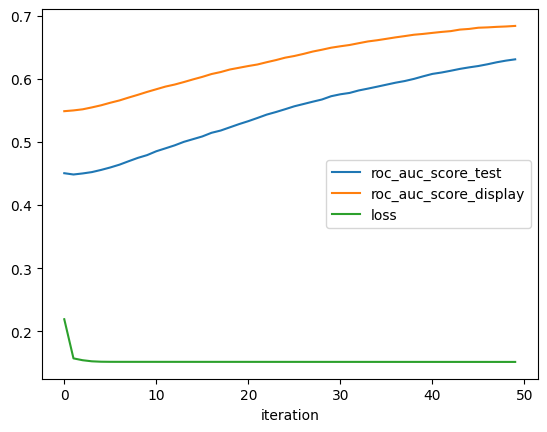

In [50]:
from tg.grammar_ru.ml.components.training_task_factory import TaskFactory
from sklearn.metrics import roc_auc_score
from tg.common import Logger

class MyCandidateTask(TaskFactory):
    def _create_network(self, task, batch):
        network_factory = MyCandidateNetworkFactory(pronoun_pc, candidate_pc, 50)
        return network_factory.create(None, batch)
        
    def create_task(self, data, env):
        metrics = bt.MetricPool().add_sklearn(roc_auc_score)
        self.instantiate_default_task(epoch_count=50, batch_size=1000, mini_batch_size=None, metric_pool=metrics)
        self.setup_batcher(data, [pronoun_extractor, candidate_extractor, get_binary_label_extractor()])
        self.setup_model(self._create_network, learning_rate=1)

#little_idb = IndexedDataBundle(little_db.index, little_db) 
task = MyCandidateTask()
result = task.run(little_db)
pd.DataFrame(result['output']['history']).set_index('iteration').plot()